## **Model Building - Approach**

1. Data preparation.
2. Partition the data into a train and test set.
3. Build a model on the train data.
4. Tune the model if required.
5. Test the data on the test set.

### **Importing the libraries and overview of the dataset**

In [96]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import sklearn
import sklearn.ensemble

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import optuna
import shap

import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
nltk.download('stopwords')
import string


from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import shap as sh


[nltk_data] Downloading package stopwords to /Users/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:

# import lightgbm

### **Define Metrics**


In [98]:
# Creating metric function

def metrics_score(actual, predicted):
    
    print(classification_report(actual, predicted))
    
    cm = confusion_matrix(actual, predicted)
    
    plt.figure(figsize = (8, 5))
    
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Negative', 'Positive'], yticklabels = ['False', 'True'])
    plt.ylabel('Actual')
    
    plt.xlabel('Predicted')
    
    plt.show()

In [99]:
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    
    predictors: independent variables
    
    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    recall = recall_score(target, pred,average = 'macro')                 # To compute recall
    
    precision = precision_score(target, pred, average = 'macro')              # To compute precision
               
    acc = accuracy_score(target, pred)                                 # To compute accuracy score
    

    # Creating a dataframe of metrics
    
    df_perf = pd.DataFrame(
        {
            "Precision":  precision,
            "Recall":  recall,
            "Accuracy": acc,
        },
        
        index = [0],
    )

    return df_perf

### **Loading the Dataset**

In [100]:
data = pd.read_csv("./kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",encoding='latin-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### **Dataset**¶
We use the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

It contains the following 6 fields:

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

### **EDA**

In [101]:
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "TweetText"] # positive is 1
data.columns = DATASET_COLUMNS

In [102]:
data.dtypes

sentiment     int64
ids           int64
date         object
flag         object
user         object
TweetText    object
dtype: object

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   ids        1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   flag       1599999 non-null  object
 4   user       1599999 non-null  object
 5   TweetText  1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [104]:
data.nunique()

sentiment          2
ids          1598314
date          774362
flag               1
user          659775
TweetText    1581465
dtype: int64

In [105]:
data.describe(include='all')

,sentiment,ids,date,flag,user,TweetText
count,1.599999e+06,1.599999e+06,1599999,1599999,1599999,1599999
unique,NaN,NaN,774362,1,659775,1581465
top,NaN,NaN,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,20,1599999,549,210
mean,2.000001e+00,1.998818e+09,NaN,NaN,NaN,NaN
std,2.000001e+00,1.935757e+08,NaN,NaN,NaN,NaN
min,0.000000e+00,1.467811e+09,NaN,NaN,NaN,NaN
25%,0.000000e+00,1.956916e+09,NaN,NaN,NaN,NaN
50%,4.000000e+00,2.002102e+09,NaN,NaN,NaN,NaN
75%,4.000000e+00,2.177059e+09,NaN,NaN,NaN,NaN


### **Data Preprocessing**

In [106]:
data.drop(columns=['ids','date','flag','user'],inplace=True)

In [107]:
sample_size = 16000

positive_data = data[data.sentiment==4].iloc[:sample_size]
print(positive_data.shape)
negative_data = data[data.sentiment==0].iloc[:sample_size]
print(negative_data.shape)
data = pd.concat([positive_data,negative_data],axis = 0)
print(data.shape)
data.head()

data.describe().T

(16000, 2)
(16000, 2)
(32000, 2)


,count,mean,std,min,25%,50%,75%,max
sentiment,32000.0,2.0,2.000031,0.0,0.0,2.0,4.0,4.0


In [108]:

# Removing Twitter Handles (@user)
data['Clean_TweetText'] = data['TweetText'].str.replace("@", "") 
# Removing links
data['Clean_TweetText'] = data['Clean_TweetText'].str.replace(r"http\S+", "") 
# Removing Punctuations, Numbers, and Special Characters
data['Clean_TweetText'] = data['Clean_TweetText'].str.replace("[^a-zA-Z]", " ") 
# Remove stop words

stopwords=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda text : remove_stopwords(text.lower()))
data.head()

,sentiment,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpets u guys r best
800000,4,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thanks twitter add sunisa got ...
800002,4,Being sick can be really cheap when it hurts t...,sick really cheap hurts much eat real food plu...
800003,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone


In [109]:
# Text Tokenization and Normalization
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: nltk.word_tokenize(x))
data.head()

,sentiment,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,"[love, health, uandpets, u, guys, r, best]"
800000,4,im meeting up with one of my besties tonight! ...,"[im, meeting, one, besties, tonight, cant, wai..."
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...","[darealsunisakim, thanks, twitter, add, sunisa..."
800002,4,Being sick can be really cheap when it hurts t...,"[sick, really, cheap, hurts, much, eat, real, ..."
800003,4,@LovesBrooklyn2 he has that effect on everyone,"[lovesbrooklyn, effect, everyone]"


In [110]:
# Now let’s stitch these tokens back together
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x]))
# Removing small words
data['Clean_TweetText'] = data['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data.head()

,sentiment,TweetText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpets guys best
800000,4,im meeting up with one of my besties tonight! ...,meeting besties tonight cant wait girl talk
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thanks twitter sunisa meet sho...
800002,4,Being sick can be really cheap when it hurts t...,sick really cheap hurts much real food plus fr...
800003,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone


In [111]:

# Map target to 4 to 1
data['sentiment'].replace(4,1,inplace=True)
data.head()



,sentiment,TweetText,Clean_TweetText
799999,1,I LOVE @Health4UandPets u guys r the best!!,love health uandpets guys best
800000,1,im meeting up with one of my besties tonight! ...,meeting besties tonight cant wait girl talk
800001,1,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thanks twitter sunisa meet sho...
800002,1,Being sick can be really cheap when it hurts t...,sick really cheap hurts much real food plus fr...
800003,1,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone


In [112]:
data['Clean_TweetText']

799999                       love health uandpets guys best
800000          meeting besties tonight cant wait girl talk
800001    darealsunisakim thanks twitter sunisa meet sho...
800002    sick really cheap hurts much real food plus fr...
800003                        lovesbrooklyn effect everyone
                                ...                        
15995           leslie stack injured rowdy think great game
15996                           ryanbader bummer love chuck
15997                                       kinda show time
15998                                 good night still four
15999                                         stephhie know
Name: Clean_TweetText, Length: 32000, dtype: object

## **Modeling**

In [113]:
count_vectorizer = CountVectorizer(stop_words='english') 
cv = count_vectorizer.fit_transform(data['Clean_TweetText'])
cv.shape


(32000, 34757)

In [114]:
x_train,x_test,y_train,y_test = train_test_split(cv,data['sentiment'] , test_size=.2,stratify=data['sentiment'], random_state=42)

### **Decision Tree Classifier**

In [115]:
# Building decision tree model
dt = DecisionTreeClassifier(class_weight = {0: 0.17, 1: 0.83}, random_state = 1)

In [116]:
# Fitting decision tree model
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.17, 1: 0.83}, random_state=1)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     12800
           1       0.99      1.00      0.99     12800

    accuracy                           0.99     25600
   macro avg       0.99      0.99      0.99     25600
weighted avg       0.99      0.99      0.99     25600



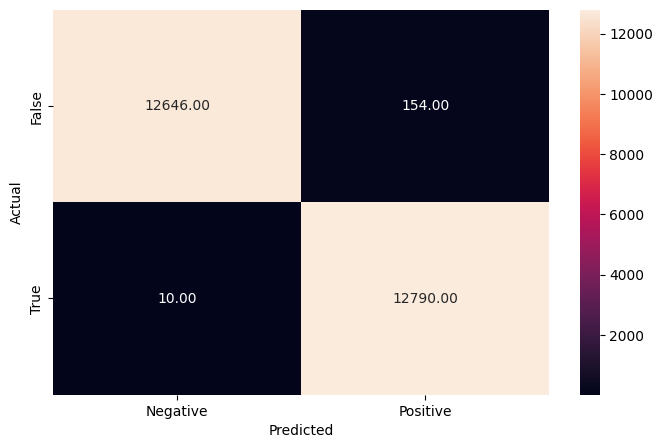

In [117]:
# Checking performance on the training dataset
y_train_pred_dt = dt.predict(x_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.68      0.60      0.64      3200
           1       0.64      0.72      0.68      3200

    accuracy                           0.66      6400
   macro avg       0.66      0.66      0.66      6400
weighted avg       0.66      0.66      0.66      6400



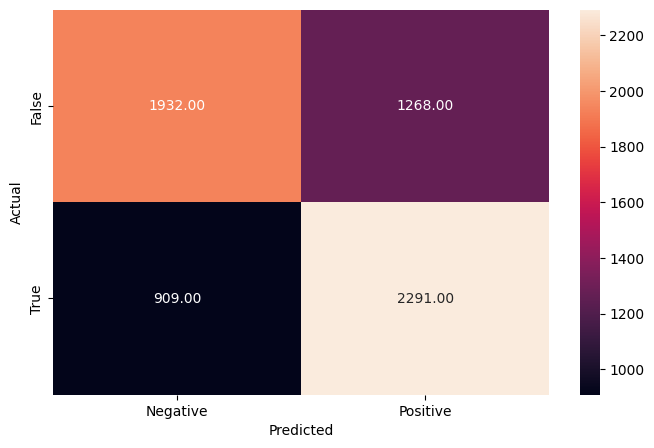

In [118]:
# Checking performance on the test dataset
y_test_pred_dt = dt.predict(x_test)

metrics_score(y_test, y_test_pred_dt)

In [119]:
dtree_test = model_performance_classification(dt,x_test,y_test)
dtree_test

,Precision,Recall,Accuracy
0,0.661881,0.659844,0.659844


In [120]:
# Choose the type of classifier
dtree_estimator = DecisionTreeClassifier(class_weight = {0: 0.17, 1: 0.83}, random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 1000), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

# Fitting the grid search on the train data
gridCV = gridCV.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data
dtree_estimator.fit(x_train, y_train)

KeyboardInterrupt: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.50      1.00      0.67       128

    accuracy                           0.50       256
   macro avg       0.25      0.50      0.33       256
weighted avg       0.25      0.50      0.33       256



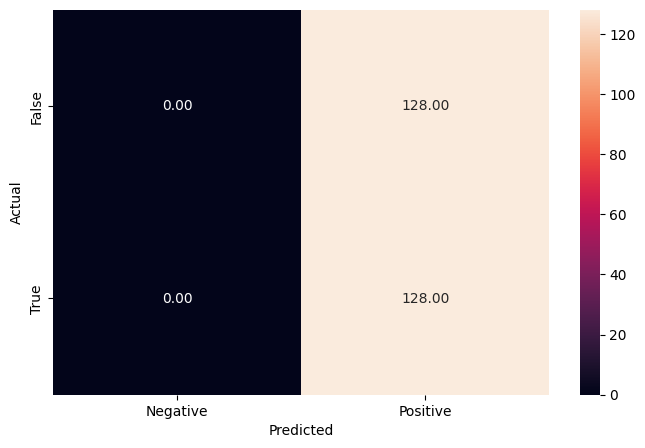

In [ ]:
# Checking performance on the training dataset
y_train_pred_dt = dtree_estimator.predict(x_train)

metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.50      1.00      0.67        32

    accuracy                           0.50        64
   macro avg       0.25      0.50      0.33        64
weighted avg       0.25      0.50      0.33        64



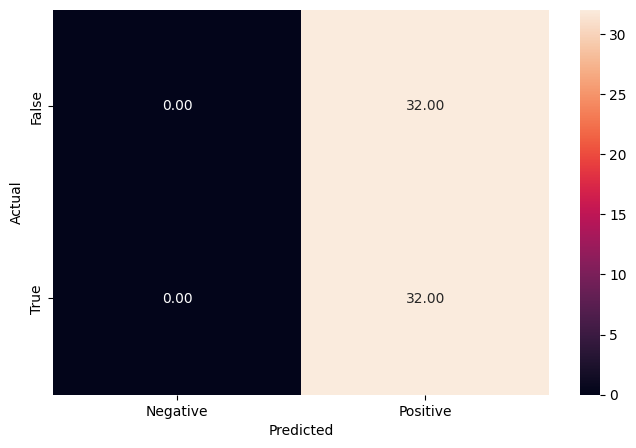

In [ ]:
# Checking performance on the test dataset
y_test_pred_dt = dtree_estimator.predict(x_test)

metrics_score(y_test, y_test_pred_dt)

In [ ]:
dtree_tuned_test = model_performance_classification(dtree_estimator,x_test,y_test)
dtree_tuned_test

,Precision,Recall,Accuracy
0,0.25,0.5,0.5


In [95]:
x_test

<64x1200 sparse matrix of type '<class 'numpy.int64'>'
	with 351 stored elements in Compressed Sparse Row format>

In [93]:
# Fitting the Explainer
explainer = sh.Explainer(dtree_estimator.predict, x_test)

# Calculating the SHAP values. The below code might take some time to run.
shap_values = explainer(x_test)

DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (1, 1200) was passed while the masker expected data of shape (1200,).

In [826]:
rf = sklearn.ensemble.RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(x_train, y_train)
print(rf.feature_importances_)

ValueError: could not convert string to float: 'lissym written tell someones spoken sucks mcfly haha loser'

In [44]:
dtree_estimator = DecisionTreeClassifier(class_weight = {0: 0.17, 1: 0.83}, random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 7), 
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [5, 10, 20, 25]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = scorer, cv = 10)

# Fitting the grid search on the train data
gridCV = gridCV.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data
dtree_estimator.fit(x_train, y_train)

ValueError: 
All the 400 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 969, in fit
    super().fit(
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 172, in fit
    X, y = self._validate_data(
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py", line 591, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "/opt/homebrew/lib/python3.10/site-packages/pandas/core/series.py", line 872, in __array__
    return np.asarray(self._values, dtype)
ValueError: could not convert string to float: 'dancing around room jamming ipod getting dizzy well twitter asked'

--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 969, in fit
    super().fit(
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 172, in fit
    X, y = self._validate_data(
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py", line 591, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py", line 856, in check_array
    array = np.asarray(array, order=order, dtype=dtype)
  File "/opt/homebrew/lib/python3.10/site-packages/pandas/core/series.py", line 872, in __array__
    return np.asarray(self._values, dtype)
ValueError: could not convert string to float: 'lettya always wanted rent love soundtrack'


### **Building the Random Forest Classifier**

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample, a decision tree makes a prediction. 

**The results from all the decision trees are combined and the final prediction is made using voting (for classification problems) or averaging (for regression problems).**

In [70]:
x_train,x_test,y_train,y_test = train_test_split(cv,data['sentiment'] , test_size=.2,stratify=data['sentiment'], random_state=42)

In [664]:
# 1. Define an objective function to be maximized.

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    # iris = sklearn.datasets.load_iris()
    # x, y = iris.data, iris.target
    x_train,x_test,y_train,y_test = train_test_split(cv,data['target'] , test_size=.2,stratify=data['target'], random_state=42)
    x = x_train
    y = y_train

    classifier_name = trial.suggest_categorical("classifier", ["RandomForest"])
    # rf_criterion = trial.suggest_categorical('rf_criterion',['gini', 'entropy', 'log_loss'])
    # rf_n_estimators = trial.suggest_int("rf_n_estimators",100,1000, log=False)
    # rf_max_depth = trial.suggest_int("rf_max_depth", 2, 100, log=False)
    # rf_min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 5, log=False)
    # rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf",1,500, log=False)
    # rf_max_leaf_nodes = trial.suggest_int("rf_max_leaf_nodes",2,100, log=True)

    
    rf_estimator = sklearn.ensemble.RandomForestClassifier(
        criterion = 'gini',
        n_estimators=108, 
        max_depth= 2,
        min_samples_split = 2,
        min_samples_leaf=1, 
        max_leaf_nodes=10
    )
    rf_estimator.fit(x_train, y_train)
    
    rf_estimator_test = model_performance_classification(rf_estimator,x_test,y_test)
    return rf_estimator_test.Recall


In [555]:
# discovery parameters
'''
        criterion = rf_criterion,
        n_estimators=rf_n_estimators, 
        max_depth=rf_max_depth, 
        min_samples_split = rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf, 
        max_leaf_nodes=rf_max_leaf_nodes
'''

'\n        criterion = rf_criterion,\n        n_estimators=rf_n_estimators, \n        max_depth=rf_max_depth, \n        min_samples_split = rf_min_samples_split,\n        min_samples_leaf=rf_min_samples_leaf, \n        max_leaf_nodes=rf_max_leaf_nodes\n'

In [475]:
# default parameters
'''
        criterion = 'gini',
        n_estimators=100, 
        max_depth=None, 
        min_samples_split = 2,
        min_samples_leaf=1, 
        max_leaf_nodes=None
'''


"\n        criterion = 'gini',\n        n_estimators=100, \n        max_depth=None, \n        min_samples_split = 2,\n        min_samples_leaf=1, \n        max_leaf_nodes=None\n"

In [674]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2022-12-17 21:10:04,668] A new study created in memory with name: no-name-d5b4472a-240b-4d80-8f7f-2ccbc34467c0
[I 2022-12-17 21:10:04,755] Trial 0 finished with value: 0.56 and parameters: {'classifier': 'RandomForest'}. Best is trial 0 with value: 0.56.
[I 2022-12-17 21:10:04,835] Trial 1 finished with value: 0.6225 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.6225.
[I 2022-12-17 21:10:04,913] Trial 2 finished with value: 0.5825 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.6225.
[I 2022-12-17 21:10:04,991] Trial 3 finished with value: 0.6025 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.6225.
[I 2022-12-17 21:10:05,071] Trial 4 finished with value: 0.6074999999999999 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0.6225.
[I 2022-12-17 21:10:05,150] Trial 5 finished with value: 0.6 and parameters: {'classifier': 'RandomForest'}. Best is trial 1 with value: 0

FrozenTrial(number=1, values=[0.6225], datetime_start=datetime.datetime(2022, 12, 17, 21, 10, 4, 756245), datetime_complete=datetime.datetime(2022, 12, 17, 21, 10, 4, 835295), params={'classifier': 'RandomForest'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)


In [64]:
importances = rf_estimator.feature_importances_
indices = np.argsort(importances)


In [874]:
K = sh.sample(x_train, 10)
explainer = sh.KernelExplainer(rf_estimator.predict, K)

shap_values1 = explainer.shap_values(x_test)


  0%|          | 0/64 [00:00<?, ?it/s]

In [888]:
x_test_range = np.arange(1,320)

In [63]:
# Fitting the Random Forest classifier on the training data

rf_estimator = RandomForestClassifier(n_estimators=108, max_depth = 87, max_leaf_nodes=6, random_state = 1)
# rf_estimator = RandomForestClassifier(random_state = 1)

rf_estimator.fit(x_train, y_train)

RandomForestClassifier(max_depth=87, max_leaf_nodes=6, n_estimators=108,
                       random_state=1)

              precision    recall  f1-score   support

           0       0.67      0.97      0.79       128
           1       0.94      0.52      0.67       128

    accuracy                           0.74       256
   macro avg       0.80      0.74      0.73       256
weighted avg       0.80      0.74      0.73       256



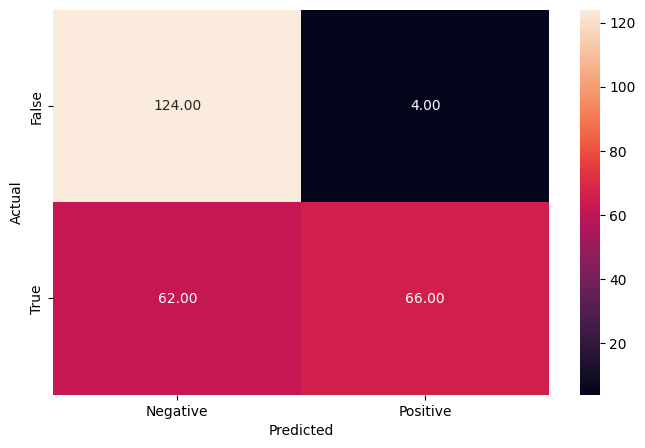

In [71]:
# Checking performance on the training data
y_pred_train_rf = rf_estimator.predict(x_train)

metrics_score(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

           0       0.56      0.91      0.69        32
           1       0.75      0.28      0.41        32

    accuracy                           0.59        64
   macro avg       0.65      0.59      0.55        64
weighted avg       0.65      0.59      0.55        64



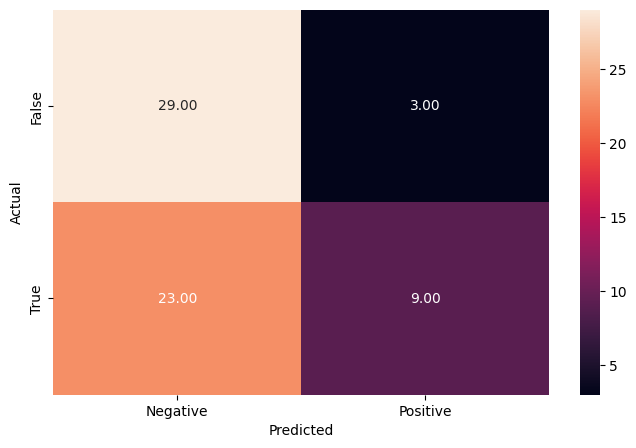

In [72]:
# Checking performance on the testing data
y_pred_test_rf = rf_estimator.predict(x_test)

metrics_score(y_test, y_pred_test_rf)

In [263]:
# print(cv)

In [264]:
'''
importances = rf_estimator.feature_importances_

columns = cv.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance, importance_df.index)
'''

"\nimportances = rf_estimator.feature_importances_\n\ncolumns = cv.columns\n\nimportance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)\n\nplt.figure(figsize = (13, 13))\n\nsns.barplot(importance_df.Importance, importance_df.index)\n"

In [73]:
rf_estimator_test = model_performance_classification(rf_estimator,x_test,y_test)
rf_estimator_test

,Precision,Recall,Accuracy
0,0.653846,0.59375,0.59375


### **Tuning the Random Forest**

**n_estimators**: The number of trees in the forest.

**min_samples_split**: The minimum number of samples required to split an internal node.

**min_samples_leaf**: The minimum number of samples required to be at a leaf node. 

**max_features{“auto”, “sqrt”, “log2”, 'None'}**: The number of features to consider when looking for the best split.

- If “auto”, then max_features=sqrt(n_features).

- If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

- If “log2”, then max_features=log2(n_features).

- If None, then max_features=n_features.

In [679]:
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier(random_state = 1)

# Grid of parameters to choose from
params_rf = {  
        "n_estimators": [100, 250, 500, 1000],
        "min_samples_leaf": np.arange(1, 4, 1),
        "max_features": [0.7, 0.9, 'auto'],
}


# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(x_train, y_train)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

In [236]:
rf_estimator_tuned.fit(x_train, y_train)

RandomForestClassifier(max_features='auto', min_samples_leaf=3, random_state=1)

              precision    recall  f1-score   support

           0       0.62      0.93      0.74       128
           1       0.86      0.42      0.57       128

    accuracy                           0.68       256
   macro avg       0.74      0.68      0.65       256
weighted avg       0.74      0.68      0.65       256



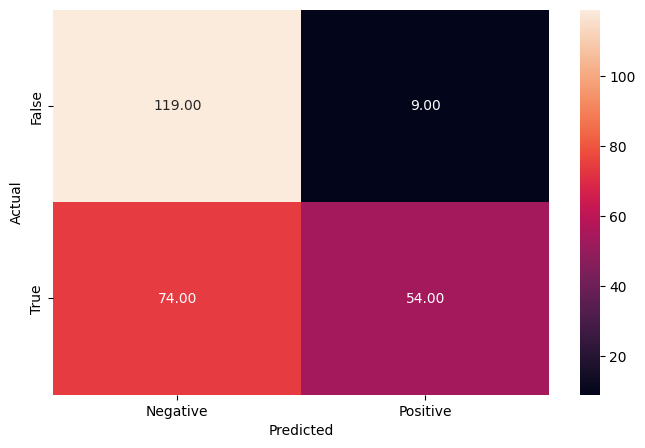

In [237]:
# Checking performance on the training data
y_pred_train_rf_tuned = rf_estimator_tuned.predict(x_train)

metrics_score(y_train, y_pred_train_rf_tuned)

              precision    recall  f1-score   support

           0       0.55      0.81      0.66        32
           1       0.65      0.34      0.45        32

    accuracy                           0.58        64
   macro avg       0.60      0.58      0.55        64
weighted avg       0.60      0.58      0.55        64



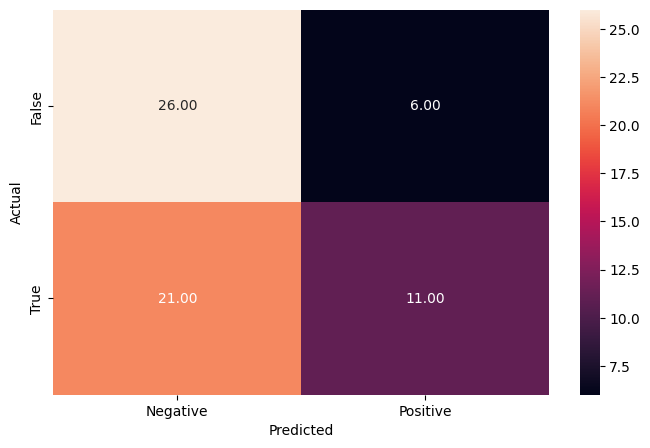

In [238]:
# Checking performance on the test data
y_pred_test_rf_tuned = rf_estimator_tuned.predict(x_test)

metrics_score(y_test, y_pred_test_rf_tuned)

In [239]:
rf_estimator_tuned_test = model_performance_classification(rf_estimator_tuned, x_test, y_test)
rf_estimator_tuned_test

,Precision,Recall,Accuracy
0,0.600125,0.578125,0.578125


In [240]:
'''
# Plotting feature importance
importances = rf_estimator_tuned.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(importance_df.Importance, importance_df.index)

'''

NameError: name 'X' is not defined

In [122]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def get_embdedings_matrix(embeddings_index, word_index, nb_words = None):
    all_embs = np.stack(embeddings_index.values())
    print('Shape of Full Embeddding Matrix', all_embs.shape)
    embed_dims = all_embs.shape[1]
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    #best to free up memory, given the size, which is usually ~3-4GB in memory
    del all_embs
    if nb_words is None:
        nb_words = len(word_index)
    else:
        nb_words = min(nb_words, len(word_index))
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_dims))
    found_vectors = 0
    words_not_found = []
    for word, i in tqdm(word_index.items()):
        if i >= nb_words: 
            continue
        embedding_vector = None
        if word in embeddings_index:
            embedding_vector = embeddings_index.get(word)
        elif word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get(word.lower())
        # for twitter check if the key is a hashtag
        elif '#'+word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get('#'+word.lower())
            
        if embedding_vector is not None: 
            found_vectors += 1
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append((word, i))

    print("% of Vectors found in Corpus", found_vectors / nb_words)
    return embedding_matrix, words_not_found

In [123]:
def load_glove(word_index):
#     print('Loading Glove')
    embed_file_path = '../input/glove840b300dtxt/glove.840B.300d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

In [ ]:
print('Loading Glove Model...')
glove_embed_matrix, words_not_found =  load_glove(tokenizer.word_index)